# PosRecoCNN Inference

Position reconstruction CNN inference pipeline for SBND detector.
Loads trained models and evaluates performance on test data.

## 1. Setup and Configuration

In [1]:
"""
Example script for running inference with trained PosRecoCNN model.
Demonstrates how to use the training pipeline for new data.
"""

import os
import sys
import json
import numpy as np
import awkward as ak
import uproot
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path

# Auto-detect training directory based on project structure
def find_training_directory():
    """Find the training directory automatically based on project structure."""
    
    # Method 1: Check if we're already in the training directory
    if os.path.exists('config.py') and os.path.exists('utils.py'):
        return os.getcwd()
    
    # Method 2: Look for sbndcode structure from common paths
    possible_bases = [
        # Standard LArSoft development paths
        "/exp/sbnd/app/users/{}/larsoft_*/srcs/sbndcode",
        "/exp/sbnd/app/users/{}/*/srcs/sbndcode", 
        # Alternative paths
        "/home/{}/sbndcode",
        "/home/{}/larsoft_*/srcs/sbndcode",
        # Current directory relatives
        "./sbndcode",
        "../sbndcode",
        "../../sbndcode",
    ]
    
    # Get current user
    import getpass
    username = getpass.getuser()
    
    # Expand paths with username and wildcards
    import glob
    expanded_paths = []
    for base in possible_bases:
        if '{}' in base:
            base = base.format(username)
        if '*' in base:
            expanded_paths.extend(glob.glob(base))
        else:
            expanded_paths.append(base)
    
    # Check each potential sbndcode directory
    for sbndcode_path in expanded_paths:
        training_path = os.path.join(sbndcode_path, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path
    
    # Method 3: Search upwards from current directory
    current = os.getcwd()
    for _ in range(5):  # Don't go too far up
        training_path = os.path.join(current, "sbndcode", "PosRecoCVN", "training")
        if os.path.exists(training_path) and os.path.exists(os.path.join(training_path, "config.py")):
            return training_path
        parent = os.path.dirname(current)
        if parent == current:  # reached root
            break
        current = parent
    
    return None

# Find and set training directory
print(">> Auto-detecting training directory...")
training_dir = find_training_directory()

if training_dir:
    print(f">> Found training directory: {training_dir}")
    if os.getcwd() != training_dir:
        print(f"* Changing directory from {os.getcwd()} to {training_dir}")
        os.chdir(training_dir)
else:
    print("! Could not find training directory automatically")
    print("* Manual setup options:")
    print("- Navigate to your training directory:")
    print("  os.chdir('/path/to/your/sbndcode/sbndcode/PosRecoCVN/training')")
    print("- Or add your training directory to Python path:")
    print("  sys.path.append('/path/to/your/training/directory')")

# Add current directory to Python path
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())

# Debug info
print(f"\n>> Current working directory: {os.getcwd()}")
print(f"* config.py exists: {os.path.exists('config.py')}")  
print(f"* utils.py exists: {os.path.exists('utils.py')}")

# Try to import local modules
config_imported = False
utils_imported = False

try:
    from config import *
    config_imported = True
    print("* config module imported successfully")
except ImportError as e:
    print(f"! config import error: {e}")

try:
    from utils import *
    utils_imported = True
    print("* utils module imported successfully")
except ImportError as e:
    print(f"! utils import error: {e}")

if not (config_imported and utils_imported):
    print("\n! If auto-detection failed, try one of these solutions:")
    print("- Manual directory change:")
    print("  os.chdir('/exp/sbnd/app/users/YOUR_USERNAME/larsoft_*/srcs/sbndcode/sbndcode/PosRecoCVN/training')")
    print("- Add to Python path:")
    print("  sys.path.append('/path/to/your/training/directory')")
    print("\n- Then restart this cell.")

print(">> PosRecoCNN Inference Setup Complete")
print("=" * 40)

2025-10-01 16:31:14.352013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-01 16:31:14.352159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-01 16:31:14.355443: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-01 16:31:14.364665: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


>> Auto-detecting training directory...
>> Found training directory: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
* Changing directory from /home/svidales to /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training

>> Current working directory: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/training
* config.py exists: True
* utils.py exists: True
* config module imported successfully
* utils module imported successfully
>> PosRecoCNN Inference Setup Complete


## 2. Test Data Loading and Processing

In [2]:
# Load test data
print(">> Loading test data for inference...")
import time
start_time = time.time()

# Load the test file (different from training file)
file = uproot.open(DATA_CONFIG['test_file'])
optree = file['opanatree']['OpAnaTree']

print(f"* Loading all test events: {optree.num_entries:,}")
arrays = []
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
    print(f"  - Loading {key}... ({i+1}/{len(DATA_CONFIG['keys_to_load'])}) [{100*(i+1)/len(DATA_CONFIG['keys_to_load']):.1f}%]")
    array = optree[key].array()
    arrays.append(array)

loading_time = time.time() - start_time

# Unpack arrays
f_ophit_PE, f_ophit_ch, f_ophit_t, nuvT, dEpromx, dEpromy, dEpromz, dEtpc, nuvZ = arrays

# Display loading statistics
print(">> Test data loaded successfully")
print(f"* Loading time: {loading_time:.2f} seconds")
print(f"* Loaded {len(arrays)} arrays:")
for i, key in enumerate(DATA_CONFIG['keys_to_load']):
    array = arrays[i]
    array_size_mb = array.nbytes / (1024*1024)
    print(f"  - {key}: {len(array):,} events, {array_size_mb:.1f} MB")

total_size_mb = sum(array.nbytes for array in arrays) / (1024*1024)
print(f"* Total test data size: {total_size_mb:.1f} MB")
print(f"* Loading speed: {total_size_mb/loading_time:.1f} MB/s")

>> Loading test data for inference...
* Loading all test events: 15
  - Loading flash_ophit_pe... (1/9) [11.1%]
  - Loading flash_ophit_ch... (2/9) [22.2%]
  - Loading flash_ophit_time... (3/9) [33.3%]
  - Loading nuvT... (4/9) [44.4%]
  - Loading dEpromx... (5/9) [55.6%]
  - Loading dEpromy... (6/9) [66.7%]
  - Loading dEpromz... (7/9) [77.8%]
  - Loading dEtpc... (8/9) [88.9%]
  - Loading nuvZ... (9/9) [100.0%]
>> Test data loaded successfully
* Loading time: 0.44 seconds
* Loaded 9 arrays:
  - flash_ophit_pe: 15 events, 0.3 MB
  - flash_ophit_ch: 15 events, 0.2 MB
  - flash_ophit_time: 15 events, 0.3 MB
  - nuvT: 15 events, 0.0 MB
  - dEpromx: 15 events, 0.0 MB
  - dEpromy: 15 events, 0.0 MB
  - dEpromz: 15 events, 0.0 MB
  - dEtpc: 15 events, 0.0 MB
  - nuvZ: 15 events, 0.0 MB
* Total test data size: 0.8 MB
* Loading speed: 1.9 MB/s


In [3]:
# Create channel dictionary
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
Type = PDSMap['OpDetType'].array()
channel_dict = {id_val: int(type_val) for id_val, type_val in zip(ID[0], Type[0])}
print(f">> Channel dictionary created: {len(channel_dict)} channels")

>> Channel dictionary created: 312 channels


## 3. Event Processing and Filtering

In [4]:
# Process events with centralized configuration
print(">> Processing test events...")
results = process_events(
    nuvT, f_ophit_PE, f_ophit_ch, f_ophit_t,
    dEpromx, dEpromy, dEpromz, dEtpc, nuvZ,
    channel_dict, FILTER_CONFIG, verbose=True
)

# Unpack results
(nuvT_final, f_ophit_PE_final, f_ophit_ch_final, f_ophit_t_final,
 dEpromx_final, dEpromy_final, dEpromz_final, dEtpc_final, nuvZ_final, stats) = results

>> Processing test events...
>> Starting optimized event processing...
Initial events: 15
Processing flashes...
Applying data validity cuts...
Applying energy cuts...
Applying position cuts...
>> Processing completed in 0.06 seconds

Initial events: 15


,Cut,Removed,Remaining,Cumulative_Eff
0,Single neutrino,9,6,0.400
1,Has flashes,0,6,0.400
2,Valid data (≠ -999 in dEprom),0,6,0.400
3,Energy cut,0,6,0.400
4,Position cut,0,6,0.400


Final efficiency: 0.400 (6/15)

* Final dataset ranges:
  dEpromx: [-159.3, 64.7]
  dEpromy: [-196.9, 170.6]
  dEpromz: [36.6, 424.2]
  dEtpc: [108.1, 1493.2]


## 4. PE Matrix and Image Creation

In [5]:
# Create PE matrix
print(">> Creating PE matrix...")
pe_matrix = create_pe_matrix(f_ophit_PE_final, f_ophit_ch_final, IMAGE_CONFIG['max_channels'])

# Load PMT maps
print(">> Loading PMT maps...")
uncoated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['uncoated'], delimiter=",", dtype=int)
coated_map = np.loadtxt(DATA_CONFIG['pmt_maps']['coated'], delimiter=",", dtype=int)
print(f"* Uncoated map shape: {uncoated_map.shape}")
print(f"* Coated map shape: {coated_map.shape}")

>> Creating PE matrix...
Creating PE matrix for 6 events x 312 channels
  Processing event 0/6 (0.0%)
>> Completed in 0.01 seconds
Matrix shape: (6, 312)
Non-zero elements: 815
Total PE: 88753.8
>> Loading PMT maps...
* Uncoated map shape: (118, 70)
* Coated map shape: (118, 70)


In [7]:
# Load saved normalization factors from training
norm_file = '/exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/inference/tf/v0901_trained_w_165k_resnet18/normalization_factors.json'
with open(norm_file, 'r') as f:
    norm_data = json.load(f)

normalization_factors = norm_data['normalization_factors']
coord_ranges = norm_data['coord_ranges']
image_config = norm_data['image_config']

print(f">> Loaded normalization factors: {normalization_factors}")
print(f"* Coordinate ranges: {coord_ranges}")

# Create images using SAVED normalization factors (critical for inference!)
print(">> Creating PE images with saved normalization...")
images, _, valid_event_mask = create_pe_images(
    pe_matrix, uncoated_map, coated_map,
    method=IMAGE_CONFIG['selection_method'],
    normalization_factors=normalization_factors  # Use training normalization!
)

print(f"* Images created: {images.shape}")
print(f"* Events kept: {np.sum(valid_event_mask)}/{len(valid_event_mask)}")

# Apply the mask to coordinate arrays to maintain synchronization with filtered images
if not np.all(valid_event_mask):
    print(f"* Synchronizing coordinate arrays with events that passed normalization...")
    dEpromx_final = np.array(dEpromx_final)[valid_event_mask]
    dEpromy_final = np.array(dEpromy_final)[valid_event_mask]
    dEpromz_final = np.array(dEpromz_final)[valid_event_mask]
    print(f"* Coordinate arrays updated to {len(dEpromx_final)} events")
else:
    print(f"* All events passed normalization checks - no coordinate filtering needed")

>> Loaded normalization factors: [11311.19140625]
* Coordinate ranges: {'x': [0, 200], 'y': [-200, 200], 'z': [0, 500]}
>> Creating PE images with saved normalization...
Creating 6 images (59×70×2)
>> All 6 events passed normalization checks
* Images created: (6, 59, 70, 2)
* Events kept: 6/6
* All events passed normalization checks - no coordinate filtering needed


## 5. Target Variable Preparation

In [8]:
# Prepare test coordinates (use absolute x)
print(">> Preparing test target variables...")
x_abs = np.abs(np.array(dEpromx_final).flatten())
y = np.array(dEpromy_final).flatten()
z = np.array(dEpromz_final).flatten()

coordinates = np.column_stack((x_abs, y, z))
print(f"* Test coordinate ranges before scaling:")
print(f"  - X (abs): [{np.min(x_abs):.1f}, {np.max(x_abs):.1f}]")
print(f"  - Y: [{np.min(y):.1f}, {np.max(y):.1f}]")
print(f"  - Z: [{np.min(z):.1f}, {np.max(z):.1f}]")

# Scale coordinates using saved config
y_test_scaled = scale_coordinates(coordinates, coord_ranges)
print(f"\n>> Scaled test coordinate ranges:")
print(f"  * X: [{np.min(y_test_scaled[:, 0]):.3f}, {np.max(y_test_scaled[:, 0]):.3f}]")
print(f"  * Y: [{np.min(y_test_scaled[:, 1]):.3f}, {np.max(y_test_scaled[:, 1]):.3f}]")
print(f"  * Z: [{np.min(y_test_scaled[:, 2]):.3f}, {np.max(y_test_scaled[:, 2]):.3f}]")

>> Preparing test target variables...
* Test coordinate ranges before scaling:
  - X (abs): [46.5, 159.3]
  - Y: [-196.9, 170.6]
  - Z: [36.6, 424.2]

>> Scaled test coordinate ranges:
  * X: [0.232, 0.797]
  * Y: [-0.984, 0.853]
  * Z: [0.073, 0.848]


## 6. Model Loading and Inference

In [10]:
# Load trained model
model_path = '/exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/inference/tf/v0901_trained_w_165k_resnet18/saved_model'
print(f">> Loading model from: {model_path}")

model = tf.saved_model.load(model_path)
print(">> Model loaded successfully")

>> Loading model from: /exp/sbnd/app/users/svidales/larsoft_develop/srcs/sbndcode/sbndcode/PosRecoCVN/inference/tf/v0901_trained_w_165k_resnet18/saved_model


2025-10-01 16:33:19.560697: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-01 16:33:19.643061: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-01 16:33:19.643595: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

>> Model loaded successfully


In [11]:
# Make predictions on test set
print(">> Making predictions on test set...")

# For SavedModel, use the serving signature
infer = model.signatures['serving_default']
predictions = infer(tf.constant(images.astype(np.float32)))

# Extract the output (the key depends on your model)
# Check available output keys
print("* Available output keys:", list(predictions.keys()))

# Usually it's something like 'dense_2' or 'output_0'
output_key = list(predictions.keys())[0]  # Take the first (and likely only) output
y_pred_scaled = predictions[output_key].numpy()

print(f">> Debug Info:")
print(f"  * Input images shape: {images.shape}")
print(f"  * Input images range: [{np.min(images):.3f}, {np.max(images):.3f}]")
print(f"  * Raw predictions shape: {y_pred_scaled.shape}")
print(f"  * Raw predictions range: [{np.min(y_pred_scaled):.3f}, {np.max(y_pred_scaled):.3f}]")

# DIAGNOSTIC: Check scaling efficiently for ALL events
print(f"\n>> DIAGNOSTIC - Raw Scaled Predictions:")
print("=" * 50)

n_events = len(y_pred_scaled)
x_vals, y_vals, z_vals = y_pred_scaled[:, 0], y_pred_scaled[:, 1], y_pred_scaled[:, 2]

# Check ranges for all events at once (vectorized)
x_ok = (0.0 <= x_vals) & (x_vals <= 1.0)
y_ok = (-1.0 <= y_vals) & (y_vals <= 1.0)  
z_ok = (0.0 <= z_vals) & (z_vals <= 1.0)
all_ok = x_ok & y_ok & z_ok

# Count and identify problematic events
out_of_range_events = ~all_ok
out_of_range_count = np.sum(out_of_range_events)

print(f"* Expected ranges: X∈[0.0,1.0], Y∈[-1.0,1.0], Z∈[0.0,1.0]")
print(f"* Events analyzed: {n_events:,}")
print(f"* Events out of range: {out_of_range_count:,}")

if out_of_range_count == 0:
    print("✅ All predictions within expected range!")
    
    # Show summary statistics for valid ranges
    print(f"* Prediction ranges:")
    print(f"  - X: [{np.min(x_vals):.6f}, {np.max(x_vals):.6f}]")
    print(f"  - Y: [{np.min(y_vals):.6f}, {np.max(y_vals):.6f}]")
    print(f"  - Z: [{np.min(z_vals):.6f}, {np.max(z_vals):.6f}]")
    
else:
    print("❌ Some predictions exceed training range!")
    
    # Show details for problematic events (limited to first 20)
    problem_indices = np.where(out_of_range_events)[0]
    n_show = min(20, len(problem_indices))
    
    print(f"* First {n_show} problematic events:")
    for i in range(n_show):
        event_idx = problem_indices[i]
        x_val, y_val, z_val = y_pred_scaled[event_idx]
        
        issues = []
        if not x_ok[event_idx]: issues.append(f"X={x_val:.3f}")
        if not y_ok[event_idx]: issues.append(f"Y={y_val:.3f}")  
        if not z_ok[event_idx]: issues.append(f"Z={z_val:.3f}")
        
        print(f"  - Event {event_idx:5d}: [{x_val:8.6f}, {y_val:8.6f}, {z_val:8.6f}] → {', '.join(issues)}")
    
    if len(problem_indices) > n_show:
        print(f"  ... and {len(problem_indices) - n_show:,} more problematic events")
    
    # Show range violations summary
    x_violations = np.sum(~x_ok)
    y_violations = np.sum(~y_ok)
    z_violations = np.sum(~z_ok)
    
    print(f"* Violations by coordinate:")
    if x_violations > 0: print(f"  - X coordinate: {x_violations:,} events ({100*x_violations/n_events:.1f}%)")
    if y_violations > 0: print(f"  - Y coordinate: {y_violations:,} events ({100*y_violations/n_events:.1f}%)")
    if z_violations > 0: print(f"  - Z coordinate: {z_violations:,} events ({100*z_violations/n_events:.1f}%)")
    
    print("! WARNING: Model predictions exceed training range - check normalization consistency!")

# Convert back to original coordinates
print(f"\n>> Converting to physical coordinates...")
y_pred_original = inverse_scale_coordinates(y_pred_scaled, coord_ranges)
y_test_original = inverse_scale_coordinates(y_test_scaled, coord_ranges)

print(f">> Predictions completed for {len(y_test_scaled):,} test events")
print(f"* Physical coordinate ranges:")
print(f"  - X: [{np.min(y_pred_original[:, 0]):.1f}, {np.max(y_pred_original[:, 0]):.1f}] cm")
print(f"  - Y: [{np.min(y_pred_original[:, 1]):.1f}, {np.max(y_pred_original[:, 1]):.1f}] cm")
print(f"  - Z: [{np.min(y_pred_original[:, 2]):.1f}, {np.max(y_pred_original[:, 2]):.1f}] cm")

>> Making predictions on test set...


2025-10-01 16:33:26.355509: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


* Available output keys: ['output_0']
>> Debug Info:
  * Input images shape: (6, 59, 70, 2)
  * Input images range: [0.000, 0.196]
  * Raw predictions shape: (6, 3)
  * Raw predictions range: [-0.953, 0.869]

>> DIAGNOSTIC - Raw Scaled Predictions:
* Expected ranges: X∈[0.0,1.0], Y∈[-1.0,1.0], Z∈[0.0,1.0]
* Events analyzed: 6
* Events out of range: 0
✅ All predictions within expected range!
* Prediction ranges:
  - X: [0.243861, 0.793088]
  - Y: [-0.952507, 0.868933]
  - Z: [0.050650, 0.853308]

>> Converting to physical coordinates...
>> Predictions completed for 6 test events
* Physical coordinate ranges:
  - X: [48.8, 158.6] cm
  - Y: [-190.5, 173.8] cm
  - Z: [25.3, 426.7] cm


## 7. Performance analysis

In [12]:
# Create pandas DataFrame for better table display
import pandas as pd

results_data = []
for i in range(len(y_test_original)):
    true_x, true_y, true_z = y_test_original[i]
    pred_x, pred_y, pred_z = y_pred_original[i]
    diff_x = pred_x - true_x
    diff_y = pred_y - true_y
    diff_z = pred_z - true_z
    
    results_data.append({
        'Event': i,
        'True_X': true_x,
        'Pred_X': pred_x,
        'Diff_X': diff_x,
        'True_Y': true_y,
        'Pred_Y': pred_y,
        'Diff_Y': diff_y,
        'True_Z': true_z,
        'Pred_Z': pred_z,
        'Diff_Z': diff_z
    })

df_results = pd.DataFrame(results_data)
n_events = len(y_test_original)

# Smart table display based on dataset size
print(f">> Detailed Results Table ({n_events:,} Test Events):")
print("=" * 100)

# Display with better formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

if n_events <= 50:
    # Small dataset: show all events
    print("* Showing all events:")
    print(df_results)
    
elif n_events <= 500:
    # Medium dataset: show first 20, last 10, and some random samples
    print("* First 20 events:")
    print(df_results.head(20))
    print("\n* Last 10 events:")
    print(df_results.tail(10))
    
    # Show some middle events
    mid_start = n_events // 2 - 5
    mid_end = n_events // 2 + 5
    print(f"\n* Middle events ({mid_start}-{mid_end}):")
    print(df_results.iloc[mid_start:mid_end])
    
else:
    # Large dataset: show strategic samples
    print("* First 10 events:")
    print(df_results.head(10))
    
    print("\n* Last 10 events:")
    print(df_results.tail(10))
    
    # Show worst and best predictions by total error
    df_results['Total_Error'] = np.sqrt(df_results['Diff_X']**2 + df_results['Diff_Y']**2 + df_results['Diff_Z']**2)
    
    print("\n* 10 Worst predictions (highest total error):")
    worst_predictions = df_results.nlargest(10, 'Total_Error')
    print(worst_predictions[['Event', 'True_X', 'Pred_X', 'Diff_X', 'True_Y', 'Pred_Y', 'Diff_Y', 'True_Z', 'Pred_Z', 'Diff_Z', 'Total_Error']])
    
    print("\n* 10 Best predictions (lowest total error):")
    best_predictions = df_results.nsmallest(10, 'Total_Error') 
    print(best_predictions[['Event', 'True_X', 'Pred_X', 'Diff_X', 'True_Y', 'Pred_Y', 'Diff_Y', 'True_Z', 'Pred_Z', 'Diff_Z', 'Total_Error']])
    
    # Show random sample
    print(f"\n* Random sample of 15 events:")
    random_sample = df_results.sample(n=15, random_state=42).sort_values('Event')
    print(random_sample[['Event', 'True_X', 'Pred_X', 'Diff_X', 'True_Y', 'Pred_Y', 'Diff_Y', 'True_Z', 'Pred_Z', 'Diff_Z']])
    
    # Clean up temporary column
    df_results = df_results.drop('Total_Error', axis=1)
    
    print(f"\n* Note: Showing selected samples from {n_events:,} total events for readability")

# Summary statistics (always shown regardless of dataset size)
diff_coords = y_pred_original - y_test_original
coord_names = ['X', 'Y', 'Z']

print(f"\n>> Performance Summary ({n_events:,} events):")
print("=" * 40)
for i, coord in enumerate(coord_names):
    diff = diff_coords[:, i]
    print(f"* {coord} coordinate:")
    print(f"  - Mean difference (Bias): {np.mean(diff):6.2f} cm     [mean(diff)]")
    print(f"  - Std difference:         {np.std(diff):6.2f} cm     [sqrt(mean((diff - mean(diff))**2))]")
    print(f"  - RMSE:                   {np.sqrt(np.mean(diff**2)):6.2f} cm     [sqrt(mean(diff**2))]")
    print(f"  - MAE:                    {np.mean(np.abs(diff)):6.2f} cm     [mean(|diff|)]")
    print()

>> Detailed Results Table (6 Test Events):
* Showing all events:
   Event  True_X  Pred_X  Diff_X  True_Y  Pred_Y  Diff_Y  True_Z  Pred_Z  Diff_Z
0      0   159.3   158.6    -0.7  -196.9  -190.5     6.4   389.7   386.7    -3.0
1      1    46.5    53.6     7.2   -88.8   -94.4    -5.6   424.2   426.7     2.4
2      2    60.5    48.8   -11.7   170.6   173.8     3.2    36.6    25.3   -11.3
3      3    64.7    59.3    -5.4    52.0    59.2     7.3    49.9    46.4    -3.5
4      4   108.1   106.5    -1.5  -174.6  -175.5    -0.9   127.0   134.4     7.4
5      5   129.1   133.2     4.1   -90.3   -82.7     7.6    64.0    56.3    -7.7

>> Performance Summary (6 events):
* X coordinate:
  - Mean difference (Bias):  -1.34 cm     [mean(diff)]
  - Std difference:           6.14 cm     [sqrt(mean((diff - mean(diff))**2))]
  - RMSE:                     6.29 cm     [sqrt(mean(diff**2))]
  - MAE:                      5.09 cm     [mean(|diff|)]

* Y coordinate:
  - Mean difference (Bias):   3.00 cm     [m

## 8. True vs Reco

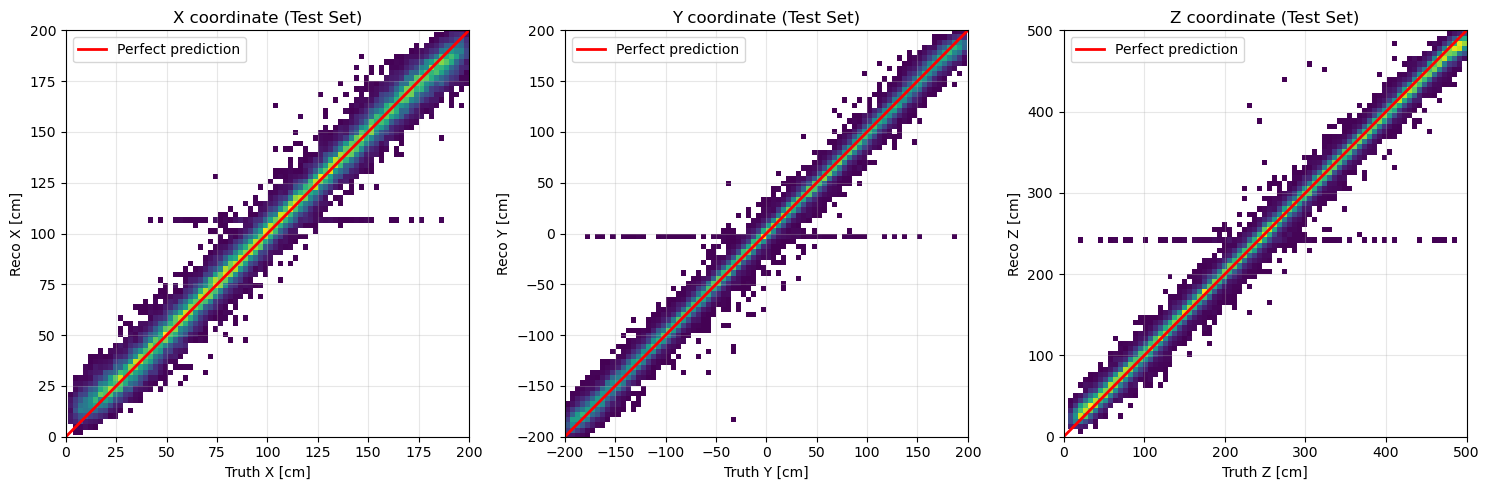

In [13]:
# Reco vs Truth comparison plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
coord_names = ['X', 'Y', 'Z']
coord_limits = [(0, 200), (-200, 200), (0, 500)]

for i, (coord, limits) in enumerate(zip(coord_names, coord_limits)):
    hist, xedges, yedges = np.histogram2d(
        y_test_original[:, i],
        y_pred_original[:, i],
        bins=ANALYSIS_CONFIG['reco_truth_comparison']['bins']
    )
    
    hist_masked = np.ma.masked_where(hist <= 2, hist)
    
    im = axs[i].pcolormesh(
        xedges, yedges, hist_masked.T,
        cmap=ANALYSIS_CONFIG['reco_truth_comparison']['cmap'],
        shading='auto'
    )
    
    axs[i].plot(limits, limits, 'r-', linewidth=2, label='Perfect prediction')
    axs[i].set_xlim(limits)
    axs[i].set_ylim(limits)
    axs[i].set_xlabel(f'Truth {coord} [cm]')
    axs[i].set_ylabel(f'Reco {coord} [cm]')
    axs[i].set_title(f'{coord} coordinate (Test Set)')
    axs[i].grid(True, alpha=0.3)
    axs[i].legend()

plt.tight_layout()
plt.show()

## 9. Bias Analysis (Test Set)

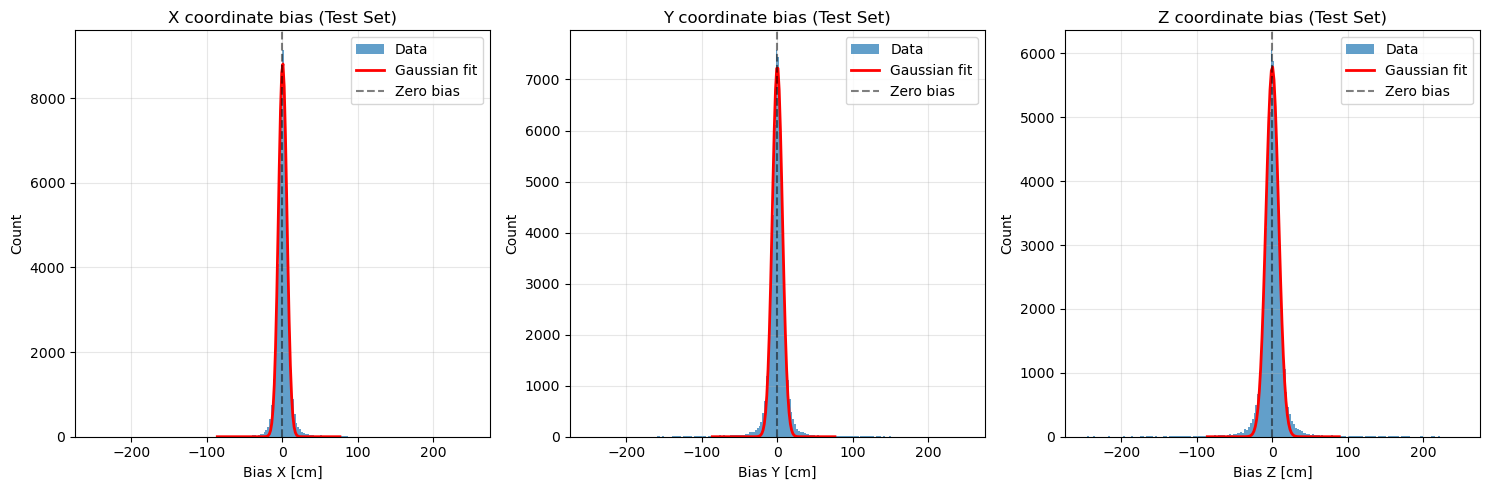


>> Test Set Bias Analysis Results:
* X coordinate:
  - Mean bias: 0.38 cm
  - Resolution (σ): 5.60 cm

* Y coordinate:
  - Mean bias: -0.07 cm
  - Resolution (σ): 6.66 cm

* Z coordinate:
  - Mean bias: -0.13 cm
  - Resolution (σ): 8.39 cm



In [12]:
# Calculate differences (bias)
diff_coords = y_pred_original - y_test_original

# Gaussian fit function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Bias analysis plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
bias_results = {}

for i, coord in enumerate(coord_names):
    diff = diff_coords[:, i]
    config = ANALYSIS_CONFIG['bias_analysis']
    
    # Create histogram
    counts, bins, _ = axs[i].hist(
        diff, 
        config['hist_bins'], 
        range=config['hist_ranges'][coord],
        alpha=0.7,
        label='Data'
    )
    
    # Prepare for Gaussian fit
    bin_centers = (bins[:-1] + bins[1:]) / 2
    fit_range = config['fit_ranges'][coord]
    
    # Fit Gaussian
    try:
        p0 = [np.max(counts), 0, 50]
        popt, _ = curve_fit(
            gaussian, 
            bin_centers[fit_range[0]:fit_range[1]], 
            counts[fit_range[0]:fit_range[1]], 
            p0=p0
        )
        
        # Plot fit
        x_fit = np.linspace(bin_centers[fit_range[0]], bin_centers[fit_range[1]], 100)
        y_fit = gaussian(x_fit, *popt)
        axs[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Gaussian fit')
        
        # Store results
        bias_results[coord] = {
            'mean': popt[1],
            'sigma': popt[2]
        }
        
    except Exception as e:
        print(f"! Warning: Could not fit Gaussian for {coord}: {e}")
        bias_results[coord] = {
            'mean': np.mean(diff),
            'sigma': np.std(diff)
        }
    
    axs[i].axvline(0, color='black', linestyle='--', alpha=0.5, label='Zero bias')
    axs[i].set_xlabel(f'Bias {coord} [cm]')
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'{coord} coordinate bias (Test Set)')
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print bias results
print("\n>> Test Set Bias Analysis Results:")
print("=" * 40)
for coord in coord_names:
    mean = bias_results[coord]['mean']
    sigma = bias_results[coord]['sigma']
    print(f"* {coord} coordinate:")
    print(f"  - Mean bias: {mean:.2f} cm")
    print(f"  - Resolution (σ): {sigma:.2f} cm")
    print()